In [108]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

## Auxiliary Functions

In [2]:
def showImage(image, name):
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def convImgToBinary(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

In [4]:
def CompareResult(BlendingResult, S2, metric):
    
    if metric == 1:
        # Signal to noise ratio, units: decibals
        ErrorValue = cv2.PSNR(S2,BlendingResult)
        print("PSNR: ", ErrorValue,"dB")
        pass
    elif metric == 2:
        # mean structural similarity index over the image, unit: index between 0 & 1
        ErrorValue = ssim(S2, BlendingResult, multichannel=True)
        print("SSIM: ", ErrorValue)
        pass
    elif metric == 3:
        # mean-squared error between two images
        ErrorValue = mse(S2, BlendingResult)
        print("MSE: ", ErrorValue)
        pass
    else:
        ErrorValue = "No Metric Specified"
        pass
    
    return ErrorValue

## Functions

In [5]:
def inpaintTalea(img, mask, inpaintRadius = 25):
    inpaintImg = cv2.inpaint(img, mask, inpaintRadius, cv2.INPAINT_TELEA)
    return inpaintImg

In [6]:
def inpaintNS(img, mask, inpaintRadius = 25):
    inpaintImg = cv2.inpaint(img, mask, inpaintRadius, cv2.INPAINT_NS)
    return inpaintImg

## Runner

In [29]:
S1 = cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/1_colour.jpeg", 1)
S2 = cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/2_colour.jpeg", 1)
ObjectMask = cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/masks/lpbooks_no_3_colour_mask_2_mask.png", 1)
ObjectMaskBin = convImgToBinary(ObjectMask)

In [30]:
inpaintResultTalea = inpaintTalea(S2, ObjectMaskBin)
showImage(inpaintResultTalea, "Inpaint Image")
for metric in range(1,4):
    errorValue = CompareResult(inpaintResultTalea, S1, metric)

PSNR:  34.05897466453426 dB
SSIM:  0.8886792678284153
MSE:  25.537765480324072


In [31]:
inpaintResultNS = inpaintNS(S2, ObjectMaskBin)
showImage(inpaintResultNS, "Inpaint Image")
for metric in range(1,4):
    errorValue = CompareResult(inpaintResultNS, S1, metric)

PSNR:  31.466803518222136 dB
SSIM:  0.8851156762620169
MSE:  46.38739764178241


#### For plotting results

In [103]:
inpRadius = 25

cols = ["S2","Mask","S1","Talea","NS"]
rows = ["LP Books               ", "Footwear               ", "Statues               "]

images = []

books = []
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/1_colour.jpeg", 1))
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/2_colour.jpeg", 1))
books.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/lp_book_no/masks/lpbooks_no_3_colour_mask_1_mask.png", 1))
images.append(books)

footwear = []
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/2_colour.jpeg", 1))
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/3_colour.jpeg", 1))
footwear.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/footwear_no/masks/footware_no_3_colour_mask_3_mask.png", 1))
images.append(footwear)

statues = []
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/1_colour.jpeg", 1))
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/2_colour.jpeg", 1))
statues.append(cv2.imread("COTSDataset-master/Part 2 - Multiple Objects/statues_oc/masks/statues_oc_3_colour_mask_4_mask.png", 1))
images.append(statues)

for imgs in images:
    mask = convImgToBinary(imgs[2])
    imgs.append(inpaintTalea(imgs[1], mask, inpRadius))
    imgs.append(inpaintNS(imgs[1], mask, inpRadius))

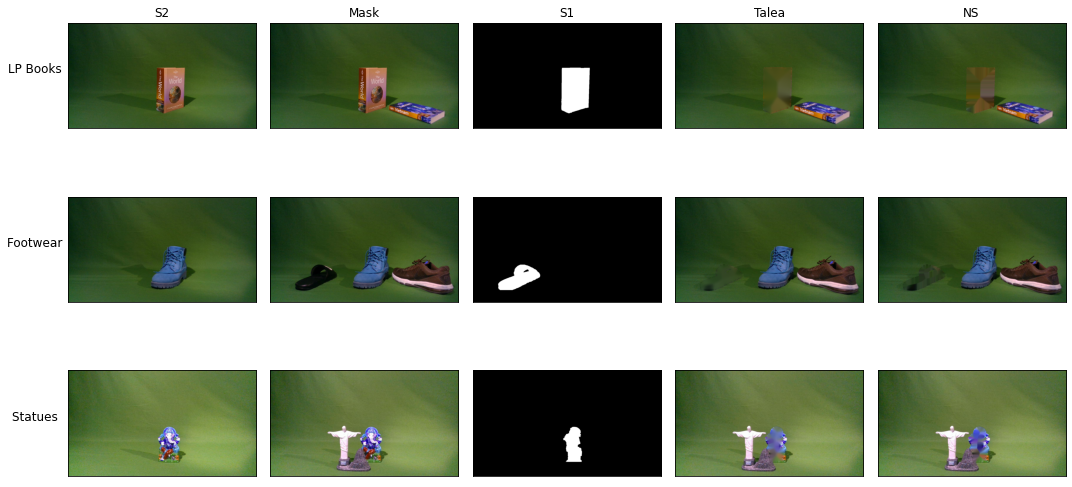

In [101]:
fig, axes = plt.subplots(nrows=len(images), ncols=len(images[0]), figsize=(15, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

for row, image in zip(axes, images):
    for ax, col in zip(row, image):
        ax.imshow(col)
    
# remove the x and y ticks
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

In [131]:
for i,imgs in enumerate(images):
    print(rows[i])
    for metric in range(1,4):
        errorValueTalea = CompareResult(imgs[3], imgs[0], metric)
        errorValueNS = CompareResult(imgs[4], imgs[0], metric)
        print()
    print("-------------------------------")

LP Books               
PSNR:  21.560850890232114 dB
PSNR:  21.787338963601247 dB

SSIM:  0.8291522652285358
SSIM:  0.8296844905073923

MSE:  453.9366746238426
MSE:  430.87020616319444

-------------------------------
Footwear               
PSNR:  23.096723274972973 dB
PSNR:  22.980846241208322 dB

SSIM:  0.8478747009744626
SSIM:  0.8455997500157596

MSE:  318.71905815972224
MSE:  327.33748155381943

-------------------------------
Statues               
PSNR:  20.380954117544533 dB
PSNR:  20.303574343862934 dB

SSIM:  0.5941909591049465
SSIM:  0.594217074063411

MSE:  595.6415006510416
MSE:  606.3493641493055

-------------------------------
